<a href="https://colab.research.google.com/github/NandaAbhilash/CN6005/blob/main/Week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load CIFAR-10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [3]:
# Normalize and convert to float32
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

In [4]:
# CIFAR-10 has 3 color channels, so no need for np.expand_dims
# The shapes are (50000, 32, 32, 3) for X_train and (10000, 32, 32, 3) for X_test

# Convert labels to one-hot encoding (required for standard classification loss)
# Note: The provided MNIST code used sparse_categorical_crossentropy which doesn't need this,
# but for a comprehensive solution and better compatibility with potential model architectures, one-hot is often preferred.
# For simplicity and consistency with the provided MNIST code's model.compile (which used 'sparse_categorical_crossentropy'),
# we'll keep y_train and y_test as they are, but if the loss function changes, one-hot encoding would be needed.
# For now, we proceed assuming 'sparse_categorical_crossentropy'.

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (50000, 32, 32, 3), y_train shape: (50000, 1)


In [6]:
def create_model_without_pooling():
    inputs = layers.Input(shape=(32, 32, 3)) # Input is 32x32x3 (color image)

    # Block 1 - Downsample using stride=2
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(x) # Strides=2 for downsampling
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)

    # Block 2 - Downsample using stride=2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same', name='last_conv_nopool')(x) # Strides=2 and named for Grad-CAM
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)

    # Classification Head
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs, name="CNN_No_Pooling")
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_nopool = create_model_without_pooling()

# Train Model 2
history_nopool = model_nopool.fit(X_train, y_train, epochs=5, validation_split=0.1, batch_size=64)

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 180s 250ms/step - accuracy: 0.3488 - loss: 1.9600 - val_accuracy: 0.5292 - val_loss: 1.3956
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 163s 230ms/step - accuracy: 0.5374 - loss: 1.2905 - val_accuracy: 0.6150 - val_loss: 1.0560
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 166s 235ms/step - accuracy: 0.6300 - loss: 1.0543 - val_accuracy: 0.6556 - val_loss: 1.0054
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 160s 227ms/step - accuracy: 0.6734 - loss: 0.9244 - val_accuracy: 0.7182 - val_loss: 0.8277
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 203s 229ms/step - accuracy: 0.7101 - loss: 0.8286 - val_accuracy: 0.7264 - val_loss: 0.8112


In [8]:
# Define Model 1 (With Pooling)
def create_model_with_pooling():
    inputs = layers.Input(shape=(32, 32, 3))

    # Block 1 - Max Pooling
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Block 2 - Max Pooling
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name='last_conv_pool')(x) # Named for Grad-CAM
    x = layers.Dropout(0.25)(x)

    # Classification Head
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs, name="CNN_With_Pooling")
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_pool = create_model_with_pooling()

# Train Model 1 (with Pooling)
print("Training Model With Pooling...")
history_pool = model_pool.fit(X_train, y_train, epochs=5, validation_split=0.1, batch_size=64)

# Evaluate Model 1
loss_pool, acc_pool = model_pool.evaluate(X_test, y_test, verbose=0)
print(f"Model With Pooling Test Accuracy: {acc_pool:.4f}")

# Evaluate Model 2
loss_nopool, acc_nopool = model_nopool.evaluate(X_test, y_test, verbose=0)
print(f"Model Without Pooling Test Accuracy: {acc_nopool:.4f}")

# Comparison Summary
print("\nAccuracy Comparison:")
print(f"Model (Pooling): {acc_pool:.4f}")
print(f"Model (No Pooling): {acc_nopool:.4f}")

Training Model With Pooling...
Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 132s 184ms/step - accuracy: 0.3432 - loss: 2.1317 - val_accuracy: 0.4498 - val_loss: 1.7068
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 141s 183ms/step - accuracy: 0.5106 - loss: 1.3623 - val_accuracy: 0.5392 - val_loss: 1.5435
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 144s 185ms/step - accuracy: 0.5768 - loss: 1.1967 - val_accuracy: 0.5798 - val_loss: 1.2101
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 128s 182ms/step - accuracy: 0.6086 - loss: 1.1055 - val_accuracy: 0.6586 - val_loss: 0.9756
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 132s 187ms/step - accuracy: 0.6377 - loss: 1.0356 - val_accuracy: 0.6384 - val_loss: 1.1038
Model With Pooling Test Accuracy: 0.6299
Model Without Pooling Test Accuracy: 0.7188

Accuracy Comparison:
Model (Pooling): 0.6299
Model (No Pooling): 0.7188


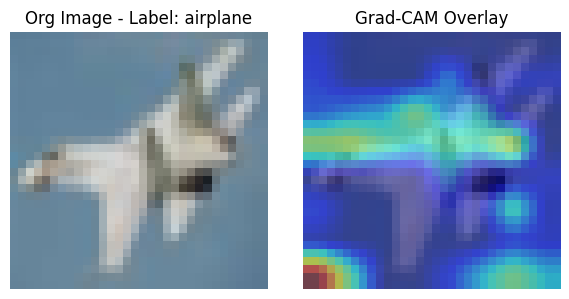

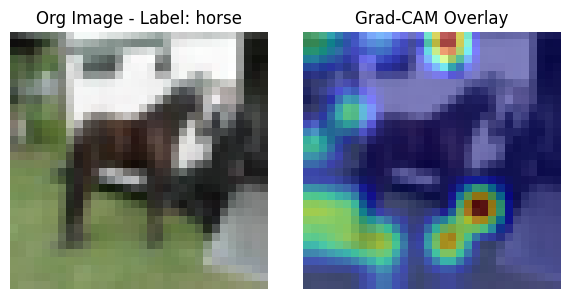

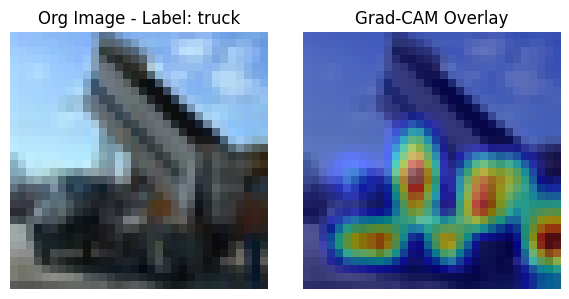

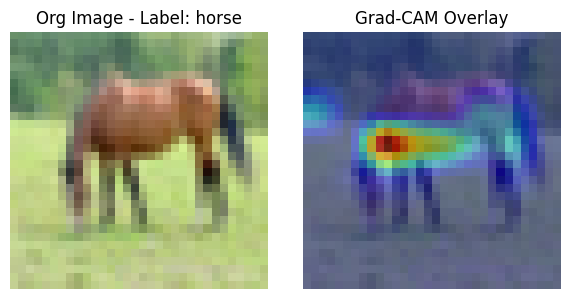

In [9]:
def compute_gradcam(model, image, label_index, layer_name):
    # grad_model needs to output the last conv layer and the final prediction layer
    grad_model = Model(inputs=model.inputs,
                       outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        # Cast input image for gradient tape and add batch dimension
        inputs = tf.cast(tf.expand_dims(image, axis=0), tf.float32)
        conv_outputs, predictions = grad_model(inputs)
        # Get the loss for the predicted label index (maximizes the score for the target class)
        loss = predictions[:, label_index]

    # Compute the gradients of the target class score w.r.t. the last conv layer's output
    grads = tape.gradient(loss, conv_outputs)
    # Global average pooling of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Multiply the activation map with the gradient importance (pooled_grads)
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply ReLU to get only features contributing positively to the class prediction
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def visualize_gradcam(model, X_test, y_test, image_index, layer_name, class_names):
    image = X_test[image_index]
    label = y_test[image_index][0] # CIFAR-10 labels are nested arrays

    # Compute Grad-CAM
    heatmap = compute_gradcam(model, image, label, layer_name)

    # Resize heatmap to match input image (32x32)
    heatmap_resized = tf.image.resize(heatmap[..., tf.newaxis], [32, 32]).numpy().squeeze()

    # Plotting
    plt.figure(figsize=(6, 3))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Org Image - Label: {class_names[label]}")
    plt.axis('off')

    # Grad-CAM Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# CIFAR-10 Class Names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Select a few images to visualize Grad-CAM on Model 1 (With Pooling)
image_indices = [10, 20, 50, 60]
layer_name_pool = 'last_conv_pool'

for i in image_indices:
    visualize_gradcam(model_pool, X_test, y_test, i, layer_name_pool, class_names)